# Examine reservoir data along side remotely sensed data

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
import datetime
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import qgrid as qg
import warnings
import pymannkendall as mk
from functools import reduce
warnings.filterwarnings('ignore')

## Folder Locations

In [2]:
root = r'C:\Users\samantha.kuzma\OneDrive - World Resources Institute'
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - MAIN FOLDERS - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# ReservoirWatch specific
data_root = os.path.join(root, "ReservoirWatch", "Data") # main data folder
raw_path = os.path.join(data_root, "Raw") # contains raw, untouched data
analysis_path = os.path.join(data_root, "Analysis") # contains processed data, maps and figures
rs_path = os.path.join(analysis_path, "RemotelySensed") # contains remotely sensed data
cwc_path = os.path.join(raw_path, "CWC") # contains raw CWC data
context_gdb = os.path.join(analysis_path, "contextual.gdb") # Holds all spatial data

#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - FIGURE FOLDERS - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 
julian_WL_range_folder = os.path.join(analysis_path, "Plots", "JulianDay_WaterLevels")
ts_WL_range_folder = os.path.join(analysis_path, "Plots", "Daily_WaterLevels")
trends_folder = os.path.join(analysis_path, "Plots", "Trends")
anomalies_path = os.path.join(analysis_path, 'reservoir_anomalies.csv')
season_path = os.path.join(analysis_path, "Plots", "Seasonal", "Precip_vs_WaterLevels")
annual_path = os.path.join(analysis_path, "Plots", "Annual_Inspection", "Mettur_2013")
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - FILES - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# File that matches each reservoir to basins (containing, upstream, downstream)
res_ids_path = os.path.join(analysis_path, "reservoir_to_IDs_lookup.csv")

#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - OTHER - - - - - - - - - - 
#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Month lookup dictionary
month = {1: "Jan", 2: "Feb", 3: "March", 4: "April", 5: "May", 6: "June",
         7: "July", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}
# Months in the 4 seasons
seasons_dict = {'Winter': [1,2], "Summer": [3, 4, 5], 
                'Monsoon': [6, 7, 8, 9], "PostMonsoon": [10, 11, 12]}

## Functions

In [3]:
def fix_dates(df_in, date_name):
    df_in[date_name] = pd.to_datetime(df_in[date_name]) # Set date as date format
    # Add Day, month, year as unique columns
    df_in['Day'] = df_in[date_name].dt.day
    df_in['Month'] = df_in[date_name].dt.month
    df_in['Year'] = df_in[date_name].dt.year
    # Create Ordinal date (sequential day count)
    df_in['OD'] = df_in[date_name].apply(lambda x: x.toordinal())
    # Find ordinal date for the beginning of each year (Jan 1)
    df_inyear = df_in[['Year', 'OD']][(df_in.Month ==1) & (df_in.Day ==1)].set_index(['Year'])
    # Add Create a Julian Date (unique sequential number for that day of the year. 0 - 365)
    df_j = pd.merge(df_in, df_inyear, how = 'left', left_on = 'Year', right_index = True)
    df_j['JD'] = df_j['OD_x'] - df_j['OD_y'] 
    # Clean up date
    df_j.drop(['OD_y'], axis=1, inplace = True)
    df_j.rename(columns = {'OD_x': "OD"}, inplace = True)
    df_j.drop_duplicates(inplace = True)
    # Add text dates
    df_j['text_month'] = df_j['Month'].apply(lambda x: month.get(x))
    df_j['text_date'] = df_j.apply(lambda x: x['text_month'] + " " + str(int(x['Year'])), axis = 1)
    return df_j

def create_clean_dates(start, end):
    df_dates = pd.DataFrame(columns = ['OD'], data = range(start, end+1))# Ordinal dates from Jan 1 2000 - Dec 31st 2020
    df_dates['DT'] = df_dates.OD.map(pd.Timestamp.fromordinal) # Convert to datetime
    df_dates['Day'] = df_dates['DT'].dt.day # find day 
    df_dates['Month'] = df_dates['DT'].dt.month # month
    df_dates['Year'] = df_dates['DT'].dt.year # year

    # Find ordinal date for the beginning of each year (Jan 1)
    df_dates_yr = df_dates[['Year', 'OD']][(df_dates.Month ==1) & (df_dates.Day ==1)].set_index(['Year'])
    # Add Create a Julian Date (unique sequential number for that day of the year. 0 - 365)
    df_j = pd.merge(df_dates, df_dates_yr, how = 'left', left_on = 'Year', right_index = True)
    df_j['JD'] = df_j['OD_x'] - df_j['OD_y'] 
    df_j.drop(['OD_y'], axis=1, inplace =True)
    df_j.rename(columns = {'OD_x': 'OD'}, inplace = True)
    # Create data labels
    df_j['text_month'] = df_j['Month'].apply(lambda x: month.get(x))
    df_j['text_date'] = df_j.apply(lambda x: x['text_month'] + " " + str(int(x['Year'])), axis = 1)
    # Text for JD charts
    df_j['text_JD'] = df_j.apply(lambda x: x['text_month'] +" " +str(x['Day']), axis = 1)
    df_j['text_JD'][df_j.Day > 1] = ""
    # Text for monthly charts
    df_j['text_monthly'] = df_j['text_date']
    df_j['text_monthly'][(df_j.Day > 1) | (df_j.Month > 1)] = ""
    # Text for daily  charts
    df_j['text_daily'] = df_j['text_monthly']
    df_j['text_daily'][(df_j.Month != 1) & (df_j.Day != 1)] = ""
    # Create reduced monthly frame 
    df_mt = df_j[df_j.Day==1].set_index('OD')
    return df_j, df_mt

def sum_by_watershedtype(df_in, field_name):
    df_piv = pd.pivot_table(df_in, values=field_name, index="OD", columns="PFAF_ID", aggfunc='mean', fill_value=0)
    # Watershed containing reservoir
    df_at = df_piv[[x for x in df_piv.columns if x in main_pf]].sum(axis = 1).to_frame(field_name+ "_at")
    # Upstream watersheds
    df_up = df_piv[[x for x in df_piv.columns if x in up_pf]].sum(axis = 1).to_frame(field_name+ "_up")
    # Downstream watersheds
    df_dn = df_piv[[x for x in df_piv.columns if x in down_pf]].sum(axis = 1).to_frame(field_name+ "_dn")
    # Incoming precip (upstream and at)
    df_in = df_piv[[x for x in df_piv.columns if x in main_pf + up_pf]].sum(axis = 1).to_frame(field_name+ "_in")
    df_concat = reduce(lambda left,right: pd.merge(left,right,on='OD'), [df_at, df_up, df_dn, df_in])
    return df_concat

def average_by_watershedtype(df_in, field_name):
    df_piv = pd.pivot_table(df_in, values=field_name, index="OD", columns="PFAF_ID", aggfunc='mean', fill_value=0)
    # Watershed containing reservoir
    df_at = df_piv[[x for x in df_piv.columns if x in main_pf]].mean(axis = 1).to_frame(field_name+ "_at")
    # Upstream watersheds
    df_up = df_piv[[x for x in df_piv.columns if x in up_pf]].mean(axis = 1).to_frame(field_name+ "_up")
    # Downstream watersheds
    df_dn = df_piv[[x for x in df_piv.columns if x in down_pf]].mean(axis = 1).to_frame(field_name+ "_dn")
    # Incoming precip (upstream and at)
    df_in = df_piv[[x for x in df_piv.columns if x in main_pf + up_pf]].mean(axis = 1).to_frame(field_name+ "_in")
    df_concat = reduce(lambda left,right: pd.merge(left,right,on='OD'), [df_at, df_up, df_dn, df_in])
    return df_concat

def season_summary(season):
    season_months = seasons_dict.get(season)
    df_season = df_monthly[df_monthly['Month'].isin(season_months)]
    df_season_avg = df_season.groupby(['Year'])[data_fields].mean()
    df_season_sum = df_season.groupby(['Year'])[data_fields].sum()
    return df_season_avg

## Read in background data

In [4]:
# Spatial data
hy6 = gpd.read_file(context_gdb, layer='P4W_hy6')
ad1 = gpd.read_file(context_gdb, layer='IND_adm1')

# List of all Reserviors
res_list = os.listdir(cwc_path)
print(res_list)

# Read in Reservoir ID list, turn PFAF ID lists from strings to list
df_resids = pd.read_csv(res_ids_path, header = 0, index_col = 0)
df_resids['PFAF_ID'] = df_resids['PFAF_ID'].apply(lambda x: ast.literal_eval(x))
df_resids['PFAF_UP'] = df_resids['PFAF_UP'].apply(lambda x: ast.literal_eval(x))
df_resids['PFAF_DN'] = df_resids['PFAF_DN'].apply(lambda x: ast.literal_eval(x))


# Remotely Sensed Options
remote_list = os.listdir(rs_path)
precip_file = 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-{:s}_IC-sum_ZS-MEAN_Scale-5000.csv'.format
temp_file = 'modis11a1_daily_TS-2000-01-01_2020-12-31_STEP-{:s}_IC-mean_ZS-MEAN_Scale-5000.csv'.format
field = '{:s}'.format
remote_list

['Bargi', 'Hirakud', 'indirasagar', 'Maithon', 'Mettur', 'Panchet', 'Pench', 'Rihand', 'Sriramsagar', 'Tenughat', 'Tilaiya']


['chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-MEAN_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-sum_ZS-SUM_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-MEAN_Scale-5000.csv',
 'chirps_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-sum_ZS-SUM_Scale-5000.csv',
 'modis11a1_daily_TS-2000-01-01_2020-12-31_STEP-day_IC-mean_ZS-MEAN_Scale-5000.csv',
 'modis11a1_daily_TS-2000-01-01_2020-12-31_STEP-month_IC-mean_ZS-MEAN_Scale-5000.csv']

## Customize analysis

In [5]:
# Reservoir
res = 'Hirakud'

# Fields
precip = field("precip_mm")
temp = field("temp_C")
wl = 'waterlevel_m'

#Dates
start_date = datetime.date(2000, 1, 1)
end_date = datetime.date(2020, 12, 31)
df_d, df_m = create_clean_dates(start_date.toordinal(), end_date.toordinal())

# Create date lists to use in graphs
daily_x = df_d['OD'].tolist()  # Ordinal dates from Jan 1 2000 - Dec 31st 2020
daily_x_txt = df_d['text_daily'].tolist() # Labels, but only label 1st 
monthly_x = df_m.index.tolist() # Ordinal dates from Jan 1 2000 - Dec 31st 2020
monthly_x_txt = df_m['text_monthly'].tolist() # Labels, but only label 1st 
julian_x = range(0, 366) # Julian dates from 0 to 365
julian_x_txt = df_d['text_JD'][df_d.Year == 2020].tolist()
seasonal_x = range(start_date.year, end_date.year+1)
seasonal_x_txt = [str(x) for x in seasonal_x]
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - WATERSHEDS - - - - - - - - - - - - - - - - - - - - - - - - 
main_pf = df_resids.loc[res, 'PFAF_ID'] # Watersheds that hold reservoir
up_pf = df_resids.loc[res, 'PFAF_UP'] # Upstream Watersheds
up_pf = list(set(up_pf) - set(main_pf))
down_pf = df_resids.loc[res, 'PFAF_DN'] # Downstream Watersheds
down_pf = list(set(down_pf) - set(main_pf))
all_pf = main_pf + up_pf + down_pf # All Watersheds
# Turns into dataframe, connect to spatial data
watershed_types = ['At reservoir' for x in main_pf] + ['Upstream' for x in up_pf] + ['Downstream' for x in down_pf] 
df_pfs = pd.DataFrame({'PFAF_ID' : all_pf, 'WATERSHED' : watershed_types}, columns=['PFAF_ID','WATERSHED'])
hy_pfs = pd.merge(hy6, df_pfs, how = 'inner', left_on = 'PFAF_ID', right_on = 'PFAF_ID')


# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - WATER LEVELS - - - - - - - - - - - - - - - - - - - - - - - - 
res_cwc = os.path.join(cwc_path, res, '{:s}_00_21.csv'.format(res)) # Reservoir CWC data file
df_r = pd.read_csv(res_cwc, header = 1) # Read in reservoir CWC data
df_r = fix_dates(df_r, 'Dates')
df_r.rename(columns = {"Current Year Level (m)": wl}, inplace = True)
df_r['level_pct'] = (df_r[wl] / df_r['Full Reservoir Level']) * 100 


#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - PRECIP - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Monthly
df_p_m = pd.read_csv(os.path.join(rs_path, precip_file('month')), index_col = 0)
df_p_m = fix_dates(df_p_m, 'date')
df_p_m.rename(columns = {"mean": precip}, inplace = True)
# Daily
df_p_d = pd.read_csv(os.path.join(rs_path, precip_file('day')), index_col = 0)
df_p_d = fix_dates(df_p_d, 'date')
df_p_d.rename(columns = {"mean": precip}, inplace = True)

#  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# - - - - - - - - - - TEMP - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Monthly
df_t_m = pd.read_csv(os.path.join(rs_path, temp_file('month')), index_col = 0)
df_t_m = fix_dates(df_t_m, 'date')
# Clean data
df_t_m = df_t_m[df_t_m.text_date != 'July 2005'] # Remove July 2005
# Convert Kelvin to Celsius (add in scale factor)
df_t_m[temp] = (df_t_m['mean'] * 0.02) - 273.15
# Sort by index and date
df_t_m = df_t_m.rename_axis('PFAF_ID').sort_values(by = ['PFAF_ID', 'date'], ascending = [True, True]).reset_index()
# Daily
df_t_d = pd.read_csv(os.path.join(rs_path, temp_file('day')), index_col = None)
df_t_d = fix_dates(df_t_d, 'date')

# # # Clean data
df_t_d = df_t_d[df_t_d['Unnamed: 0'].isin(all_pf)] # Remove rows where data is wrong (watershed ID missing)
df_t_d['PFAF_ID'] = df_t_d['Unnamed: 0'].astype(int)
df_t_d.set_index(['PFAF_ID'], inplace = True)
# # Convert Kelvin to Celsius (add in scale factor)
df_t_d[temp] = (df_t_d['mean'] * 0.02) - 273.15
# # Sort by index and date
df_t_d = df_t_d.rename_axis('PFAF_ID').sort_values(by = ['PFAF_ID', 'date'], ascending = [True, True]).reset_index()

# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - SUMMARIZE DAILY DATA TOGETHER - - - - - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
# # Summarize daily remotely sensed data by watershed type (aka at, upstream, downstream) 
df_p_daily = sum_by_watershedtype(df_p_d, precip) #Find sum of precip per type
df_t_daily = average_by_watershedtype(df_t_d, temp) # find mean temp per type
df_r_daily = df_r.filter(['OD', wl]).set_index('OD')
# Merge together
df_daily = pd.merge(df_d, df_p_daily, how = 'left', left_on = 'OD', right_index = True)
df_daily = pd.merge(df_daily, df_t_daily, how = 'left', left_on = 'OD', right_index = True)
df_daily = pd.merge(df_daily, df_r_daily, how = 'left', left_on = 'OD', right_index = True)
# Find data fields in DF
data_fields = [x for x in df_daily if (precip in x) | (temp in x) | (wl in x)]
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - SUMMARIZE MONTHLY DATA TOGETHER - - - - - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # Summarize monthly remotely sensed data by watershed type (aka at, upstream, downstream) 
df_p_monthly = sum_by_watershedtype(df_p_m, precip) #Find sum of precip per type
df_t_monthly = average_by_watershedtype(df_t_m, temp) # find mean temp per type
df_r_monthly = df_r.groupby(['Year', 'Month'])[wl].mean().to_frame(wl).reset_index() #find mean water level per month

# # Merge all monthly data together
# Merge together
df_monthly = pd.merge(df_m, df_p_monthly, how = 'left', left_index = True, right_index = True)
df_monthly = pd.merge(df_monthly, df_t_monthly, how = 'left', left_index = True, right_index = True)
df_monthly = pd.merge(df_monthly, df_r_monthly, how = 'left', left_on = ['Year', 'Month'], right_on = ['Year', 'Month'])

# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - SUMMARIZE JULIAN DATA TOGETHER - - - - - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
dmin = df_daily.groupby(['JD'])[data_fields].min().add_prefix("min_")
dmax = df_daily.groupby(['JD'])[data_fields].max().add_prefix("max_")
davg = df_daily.groupby(['JD'])[data_fields].mean().add_prefix("avg_")
dsum = df_daily.groupby(['JD'])[data_fields].sum().add_prefix("sum_")
df_jd = reduce(lambda left,right: pd.merge(left,right,on='JD'), [dmin, dmax, davg, dsum])
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   
# # - - - - - - - - - - SUMMARIZE SEASONAL DATA TOGETHER - - - - - - - - - - - - - - 
# #  - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
df_winter = season_summary("Winter")
df_summer = season_summary("Summer")
df_monsoon = season_summary("Monsoon")
df_postmonsoon = season_summary("PostMonsoon")

# View Watersheds

Text(0.5, 1.0, 'Hirakud Watersheds')

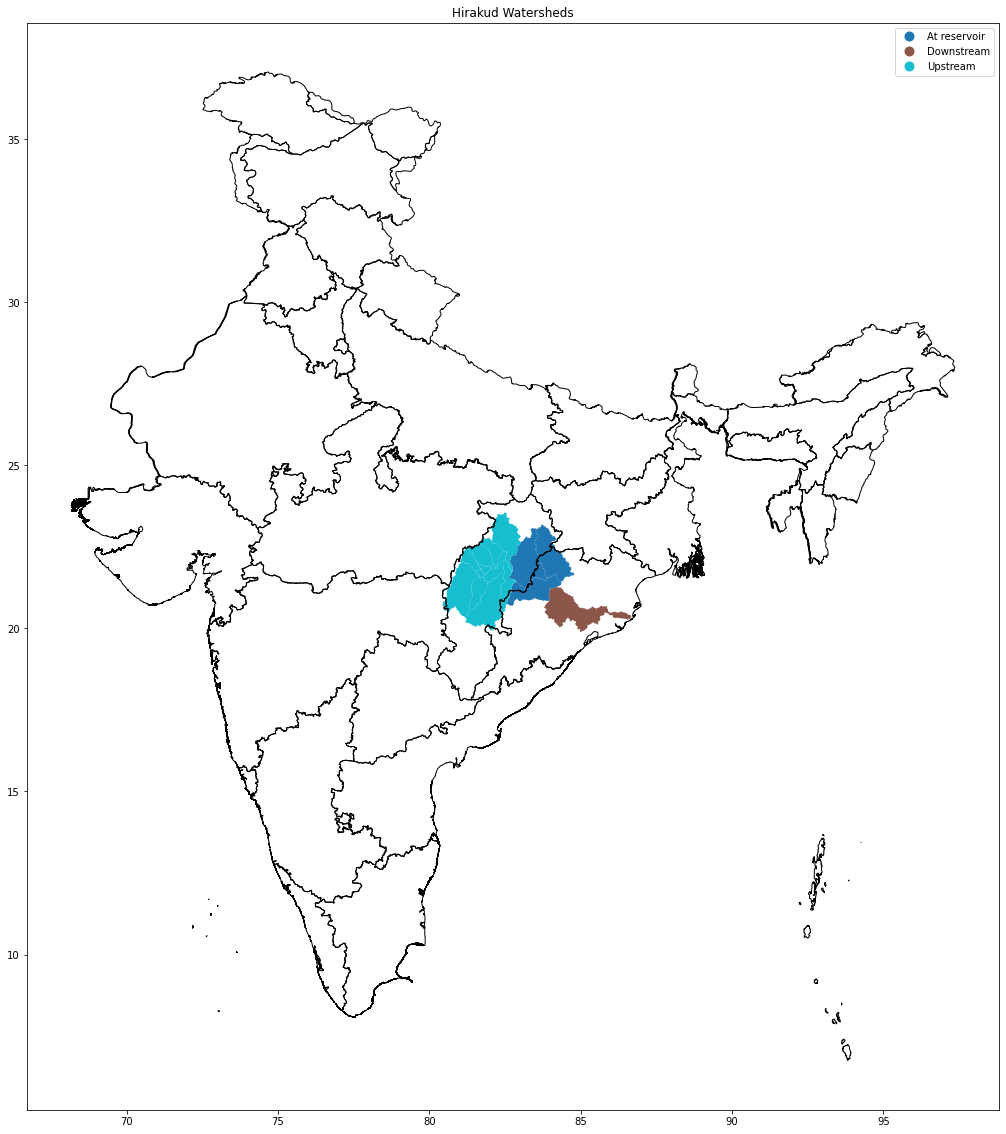

In [6]:
# Plot Watershed changes
fig, ax = plt.subplots(figsize = (25,20)) 
hy_pfs.plot(column='WATERSHED', cmap = 'tab10', legend=True, ax=ax);
ad1.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax)
plt.title("{:s} Watersheds".format(res.title()))

# Mann-Kendall Trend Test

In [7]:
df_mk = pd.DataFrame(index = ['daily', 'monthly', 'winter', 'summer', 'monsoon', 'postmonsoon'], columns = data_fields)
for i in data_fields:
    df_mk.loc['daily', i] = mk.original_test(df_daily[i])[0]
    df_mk.loc['monthly', i] = mk.original_test(df_monthly[i])[0]
    df_mk.loc['winter', i] = mk.original_test(df_winter[i])[0]
    df_mk.loc['summer', i] = mk.original_test(df_summer[i])[0]
    df_mk.loc['monsoon', i] = mk.original_test(df_monsoon[i])[0]
    df_mk.loc['postmonsoon', i] = mk.original_test(df_postmonsoon[i])[0]

df_mk

,precip_mm_at,precip_mm_up,precip_mm_dn,precip_mm_in,temp_C_at,temp_C_up,temp_C_dn,temp_C_in,waterlevel_m
daily,increasing,increasing,increasing,increasing,decreasing,decreasing,decreasing,decreasing,increasing
monthly,no trend,no trend,no trend,no trend,decreasing,no trend,decreasing,no trend,increasing
winter,no trend,no trend,no trend,no trend,decreasing,decreasing,decreasing,decreasing,increasing
summer,no trend,no trend,increasing,no trend,decreasing,no trend,decreasing,no trend,increasing
monsoon,no trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend,no trend
postmonsoon,no trend,no trend,no trend,no trend,no trend,no trend,decreasing,no trend,increasing


In [8]:
mk.original_test(df_daily[wl])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=13.645207025865957, Tau=0.1089170964558089, s=2652102.0, var_s=37776338402.666664, slope=0.00022161422708618395, intercept=187.7067879616963)

# Daily Data

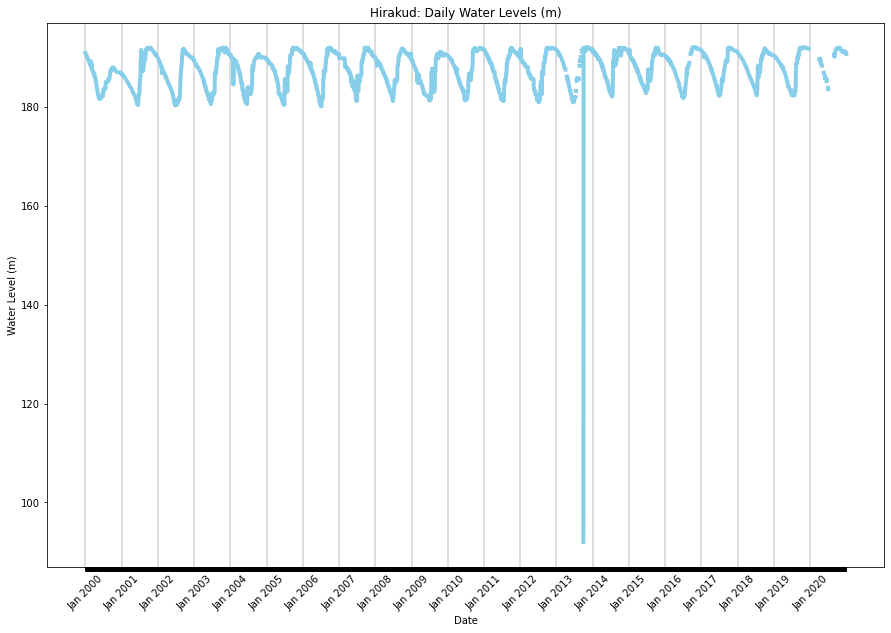

In [9]:
# Water Levels
plt.figure(figsize=(15,10))
# Define X values
x = daily_x
my_xticks = daily_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Define Y values
y1 = df_daily[wl].tolist()
# Add grid
jan1_ods = df_d['OD'][df_d.text_daily !=""].tolist()
for j in jan1_ods:
    plt.axvline(x=j, color = 'lightgray') 
# Create plot
plt.plot( x, y1, color='skyblue', linewidth=4)
# Add legend and labels
plt.title("{:s}: Daily Water Levels (m)".format(res))
plt.xlabel('Date')
plt.ylabel('Water Level (m)')

# Show plot
plt.show()


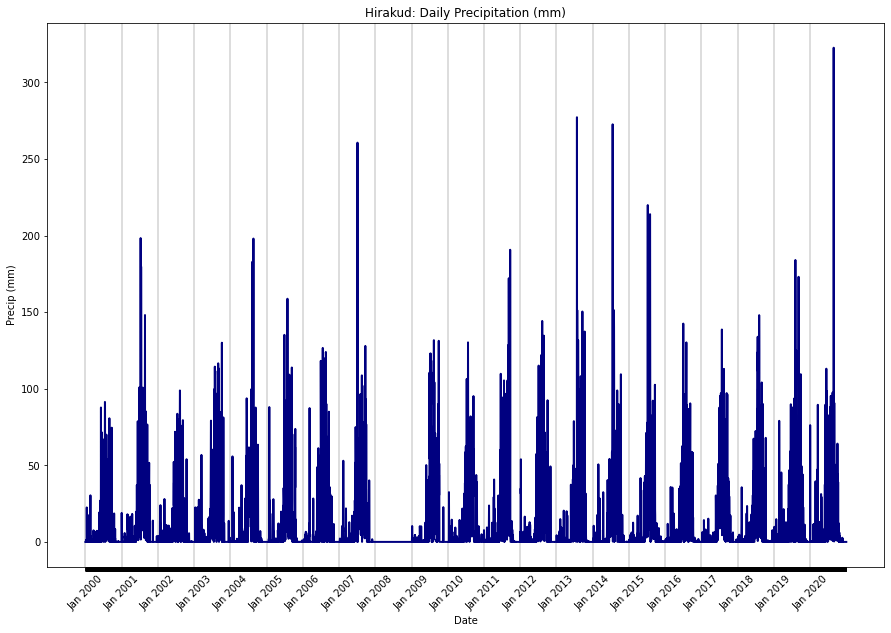

In [10]:
# Precip
plt.figure(figsize=(15,10))
# Define X values
x = daily_x
my_xticks = daily_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Define Y values
y1 = df_daily[precip + "_at"].tolist()
# Add grid
jan1_ods = df_d['OD'][df_d.text_daily !=""].tolist()
for j in jan1_ods:
    plt.axvline(x=j, color = 'lightgray') 
# Create plot
plt.plot( x, y1, color='navy', linewidth=2)
# Add legend and labels
plt.title("{:s}: Daily Precipitation (mm)".format(res))
plt.xlabel('Date')
plt.ylabel('Precip (mm)')

# Show plot
plt.show()


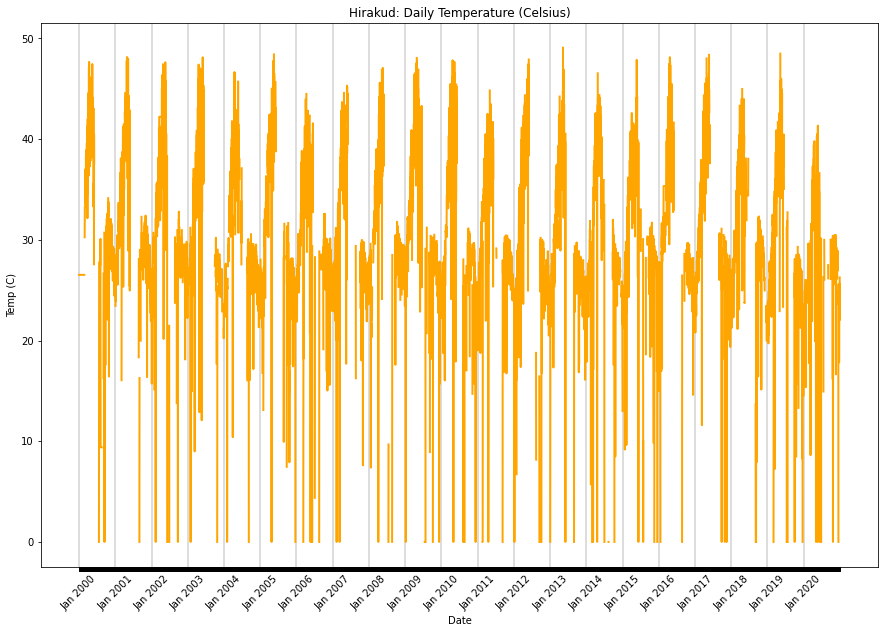

In [11]:
# Temp
plt.figure(figsize=(15,10))
# Define X values
x = daily_x
my_xticks = daily_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Define Y values
y1 = df_daily[temp + "_at"].tolist()
# Add grid
jan1_ods = df_d['OD'][df_d.text_daily !=""].tolist()
for j in jan1_ods:
    plt.axvline(x=j, color = 'lightgray') 
# Create plot
plt.plot( x, y1, color='orange', linewidth=2)
# Add legend and labels
plt.title("{:s}: Daily Temperature (Celsius)".format(res))
plt.xlabel('Date')
plt.ylabel('Temp (C)')

# Show plot
plt.show()


# Monthly Data

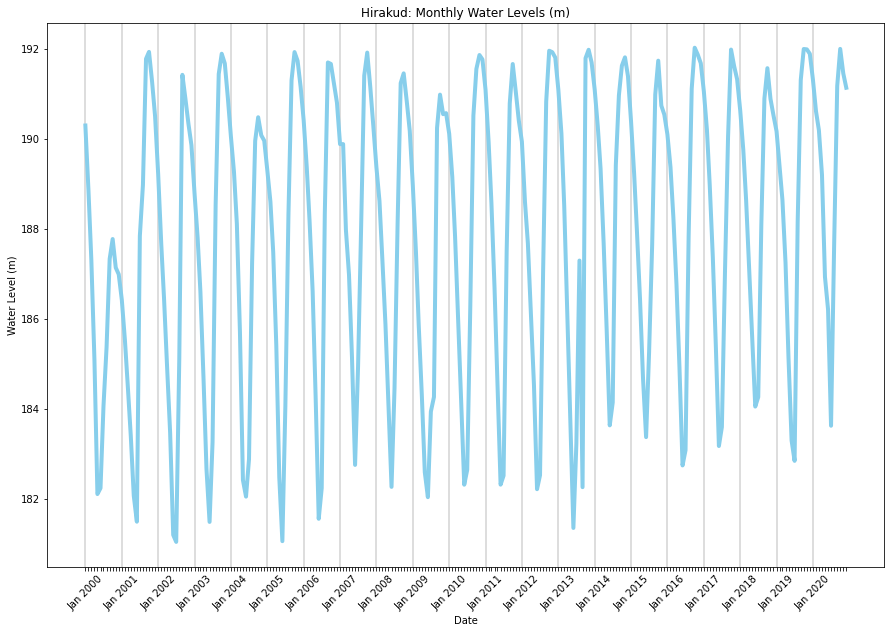

In [12]:
# Water Levels
plt.figure(figsize=(15,10))
# Define X values
x = monthly_x
my_xticks = monthly_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Define Y values
y1 = df_monthly[wl].tolist()
# Add grid
jan1_ods = df_m.index[df_m.text_monthly !=""].tolist()
for j in jan1_ods:
    plt.axvline(x=j, color = 'lightgray') 
# Create plot
plt.plot( x, y1, color='skyblue', linewidth=4)
# Add legend and labels
plt.title("{:s}: Monthly Water Levels (m)".format(res))
plt.xlabel('Date')
plt.ylabel('Water Level (m)')

# Show plot
plt.show()

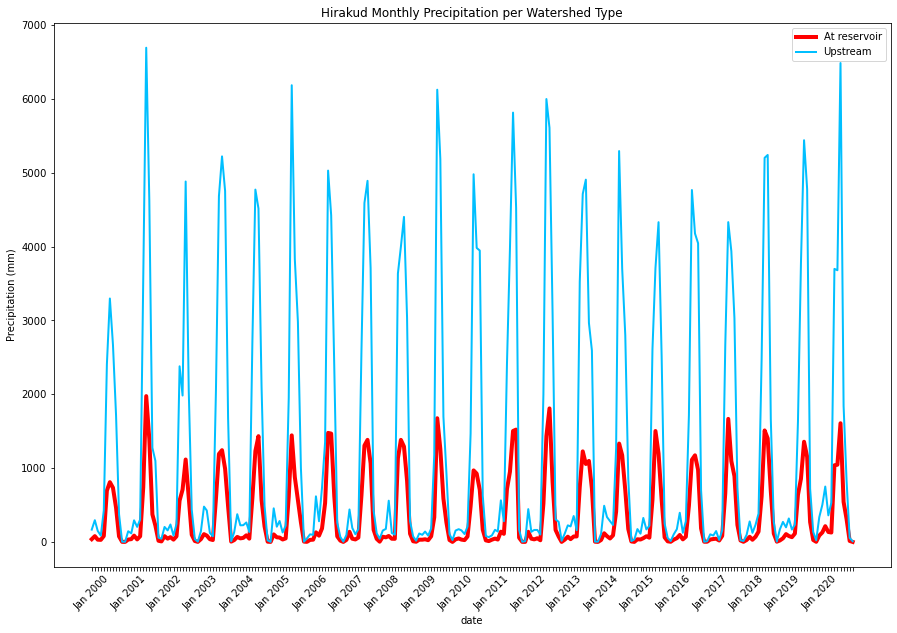

In [13]:
fig,ax = plt.subplots(figsize=(15,10))
lbl = "{:s}".format

x = monthly_x
my_xticks = monthly_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels

yat = df_monthly[precip + "_at"].tolist()
yup = df_monthly[precip + "_up"].tolist()
ydn = df_monthly[precip + "_dn"].tolist()

ax.plot(x, yat, color='red', linewidth=4, label=lbl("At reservoir"))
# ax.plot(x, ydn, color='brown', linewidth=2, label=lbl("Downstream"))
ax.plot(x, yup, color='deepskyblue', linewidth=2, label= lbl("Upstream"))
    
# plt.axvline(x=2009, color = 'red')    
ax.set_xlabel("date")
ax.set_ylabel("Precipitation (mm)")
ax.legend(loc='best')
ax.title.set_text('{:s} Monthly Precipitation per Watershed Type'.format(res))

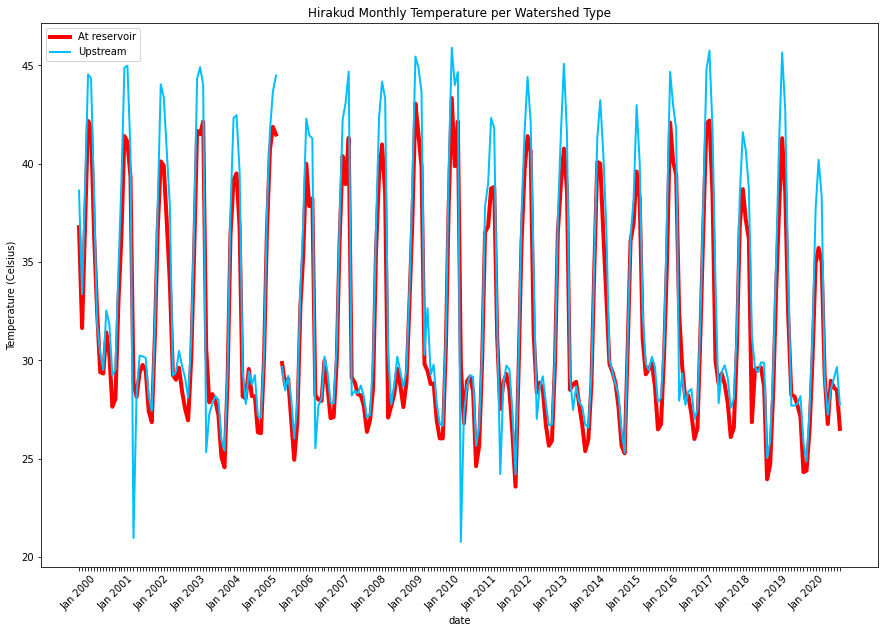

In [14]:
fig,ax = plt.subplots(figsize=(15,10))
lbl = "{:s}".format

x = monthly_x
my_xticks = monthly_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels

yat = df_monthly[temp + "_at"].tolist()
yup = df_monthly[temp + "_up"].tolist()
ydn = df_monthly[temp + "_dn"].tolist()

ax.plot(x, yat, color='red', linewidth=4, label=lbl("At reservoir"))
# ax.plot(x, ydn, color='brown', linewidth=2, label=lbl("Downstream"))
ax.plot(x, yup, color='deepskyblue', linewidth=2, label= lbl("Upstream"))
    
# plt.axvline(x=2009, color = 'red')    
ax.set_xlabel("date")
ax.set_ylabel("Temperature (Celsius)")
ax.legend(loc='best')
ax.title.set_text('{:s} Monthly Temperature per Watershed Type'.format(res))

## Compare Monthly

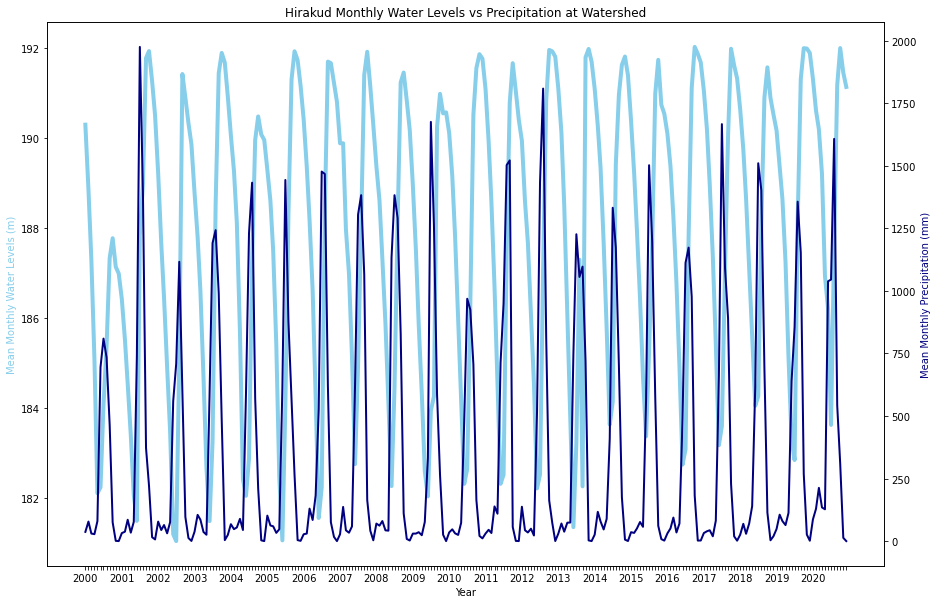

In [15]:
x = monthly_x
my_xticks = monthly_x_txt
my_xticks_slim = [i.replace("Jan ", "") for i in my_xticks]
# Create Y values from reservoir and precip data
y1 = df_monthly[wl].tolist()
y2 = df_monthly[precip + "_at"].tolist()

# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'skyblue', linewidth =4 )
ax2.plot(x, y2, 'navy', linewidth =2 )
plt.xticks(x, my_xticks_slim, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Mean Monthly Precipitation (mm)', color='navy')
ax1.title.set_text('{:s} Monthly Water Levels vs Precipitation at Watershed'.format(res))
# ax1.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.show()

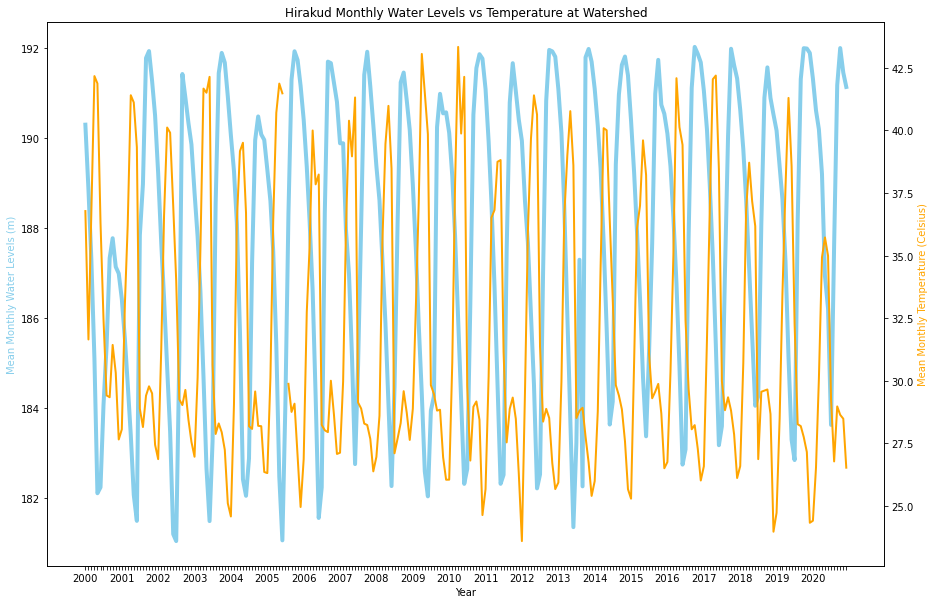

In [16]:
# WL vs Temp
x = monthly_x
my_xticks = monthly_x_txt
my_xticks_slim = [i.replace("Jan ", "") for i in my_xticks]
# Create Y values from reservoir and precip data
y1 = df_monthly[wl].tolist()
y2 = df_monthly[temp + "_at"].tolist()

# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'skyblue', linewidth =4 )
ax2.plot(x, y2, 'orange', linewidth =2 )
plt.xticks(x, my_xticks_slim, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Mean Monthly Temperature (Celsius)', color='orange')
ax1.title.set_text('{:s} Monthly Water Levels vs Temperature at Watershed'.format(res))
# ax1.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.show()

# Julian Day Data

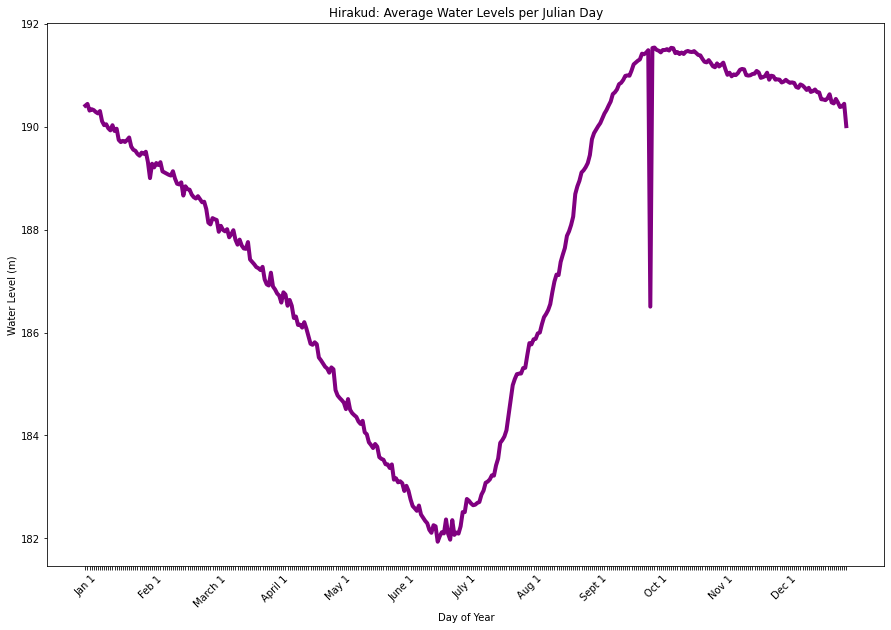

In [17]:

# Water Levels
plt.figure(figsize=(15,10))
# Define X values
x = julian_x
my_xticks = julian_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Define Y values
yavg = df_jd["avg_" + wl].tolist()
ymin = df_jd["min_" + wl].tolist()
ymax = df_jd["max_" + wl].tolist()

plt.plot( x, yavg, color='purple', linewidth=4)
# plt.plot( x, ymin, color='red', linewidth=2)
# plt.plot( x, ymax, color='deepskyblue', linewidth=2)
plt.title("{:s}: Average Water Levels per Julian Day".format(res))
plt.xlabel('Day of Year')
plt.ylabel('Water Level (m)')
# Show plot
plt.show()

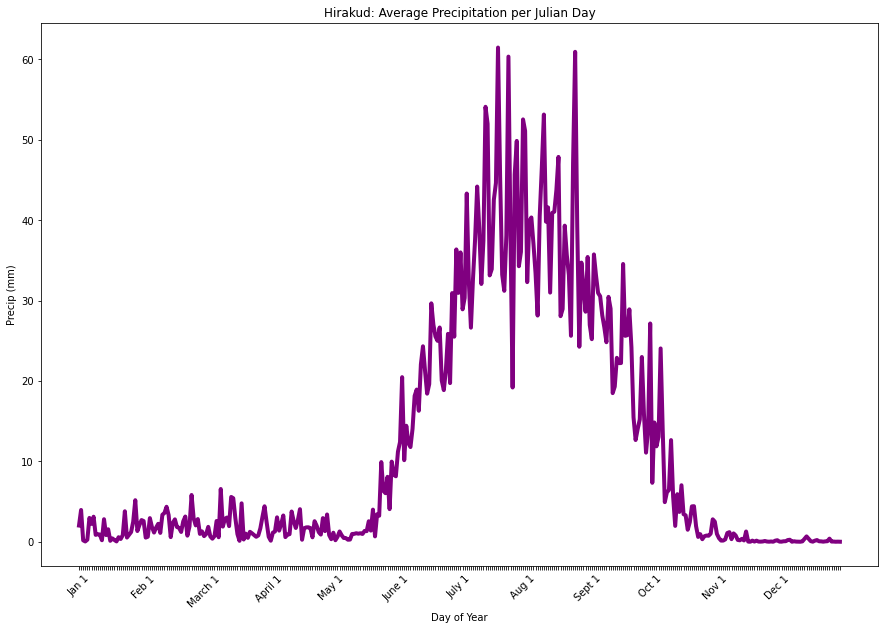

In [18]:

# Precip
plt.figure(figsize=(15,10))
# Define X values
x = julian_x
my_xticks = julian_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Define Y values
yavg = df_jd["avg_" + precip + "_at"].tolist()
ymin = df_jd["min_" + precip + "_at"].tolist()
ymax = df_jd["max_" + precip + "_at"].tolist()

plt.plot( x, yavg, color='purple', linewidth=4)
# plt.plot( x, ymin, color='red', linewidth=2)
# plt.plot( x, ymax, color='deepskyblue', linewidth=2)
plt.title("{:s}: Average Precipitation per Julian Day".format(res))
plt.xlabel('Day of Year')
plt.ylabel('Precip (mm)')
# Show plot
plt.show()

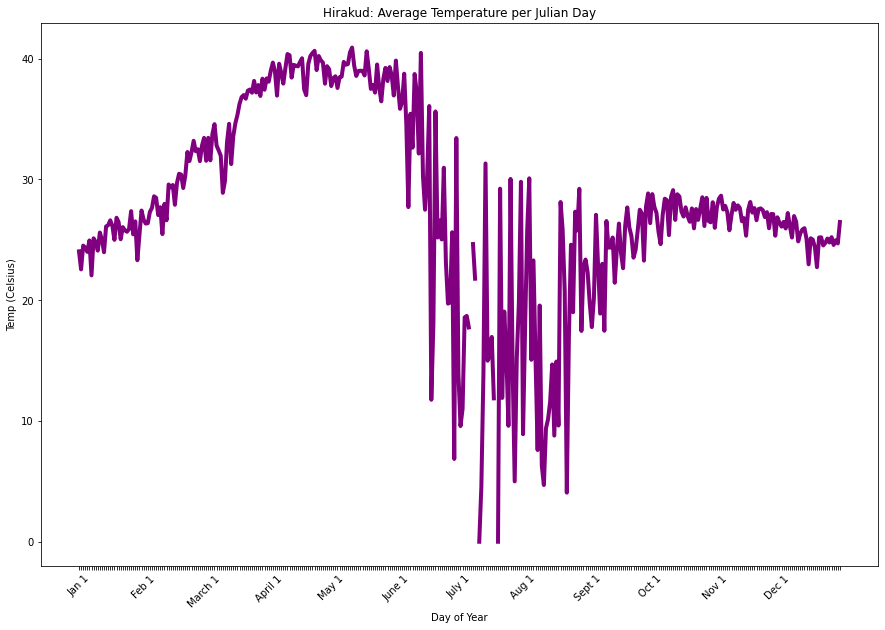

In [19]:

# Water Levels
plt.figure(figsize=(15,10))
# Define X values
x = julian_x
my_xticks = julian_x_txt
plt.xticks(x, my_xticks, rotation=45) # Create plot labels
# Define Y values
yavg = df_jd["avg_" + temp + "_at"].tolist()
ymin = df_jd["min_" + temp + "_at"].tolist()
ymax = df_jd["max_" + temp + "_at"].tolist()

plt.plot( x, yavg, color='purple', linewidth=4)
# plt.plot( x, ymin, color='red', linewidth=2)
# plt.plot( x, ymax, color='deepskyblue', linewidth=2)
plt.title("{:s}: Average Temperature per Julian Day".format(res))
plt.xlabel('Day of Year')
plt.ylabel('Temp (Celsius)')
# Show plot
plt.show()

# Seasonal Data

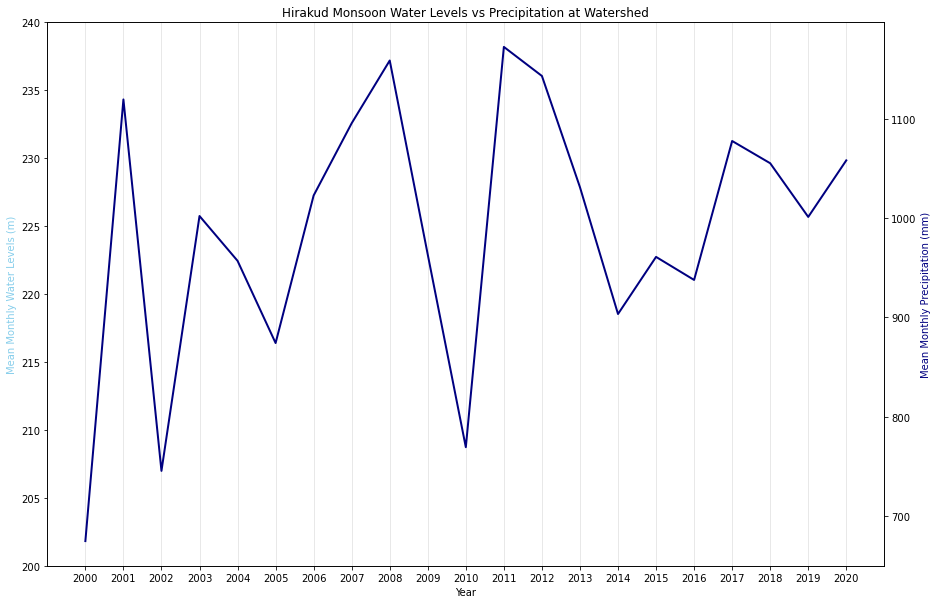

In [20]:
seas = 'Monsoon'
# Water Level vs. Temp
df_s = season_summary(seas)

x = seasonal_x
my_xticks = seasonal_x_txt

# Create Y values from reservoir and precip data
y1 = df_s[wl].tolist()
y2 = df_s[precip + "_at"].tolist()

# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'skyblue', linewidth =4 )
ax2.plot(x, y2, 'navy', linewidth =2 )
plt.xticks(x, my_xticks, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
ax1.set_ylim(200, 240)
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Mean Monthly Precipitation (mm)', color='navy')
ax1.title.set_text('{:s} {:s} Water Levels vs Precipitation at Watershed'.format(res, seas))
ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, axis = 'x')
plt.show()

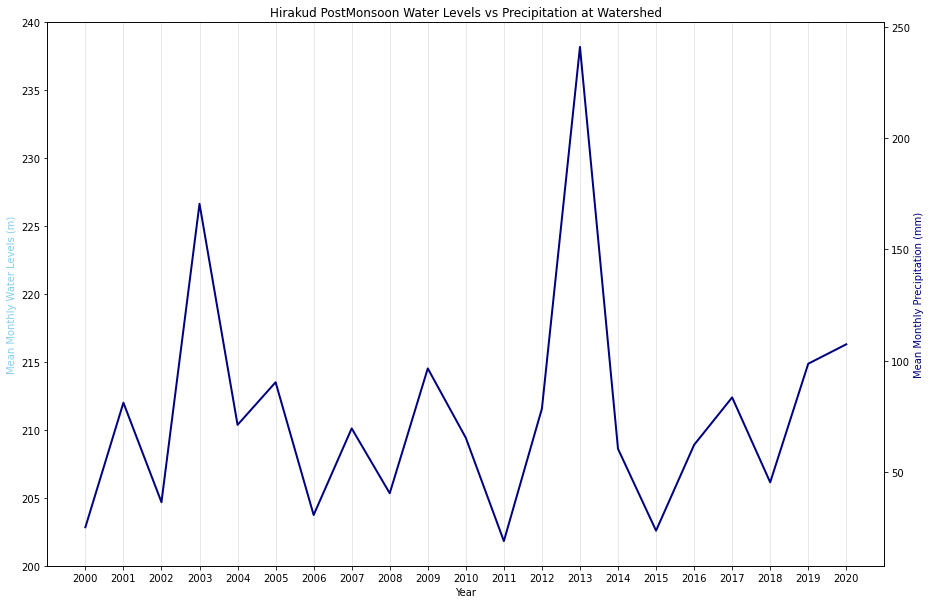

In [21]:
seas = 'PostMonsoon'
# Water Level vs. Temp
df_s = season_summary(seas)

x = seasonal_x
my_xticks = seasonal_x_txt

# Create Y values from reservoir and precip data
y1 = df_s[wl].tolist()
y2 = df_s[precip + "_at"].tolist()

# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'skyblue', linewidth =4 )
ax2.plot(x, y2, 'navy', linewidth =2 )
plt.xticks(x, my_xticks, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
ax1.set_ylim(200, 240)
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Mean Monthly Precipitation (mm)', color='navy')
ax1.title.set_text('{:s} {:s} Water Levels vs Precipitation at Watershed'.format(res, seas))
ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, axis = 'x')
plt.show()

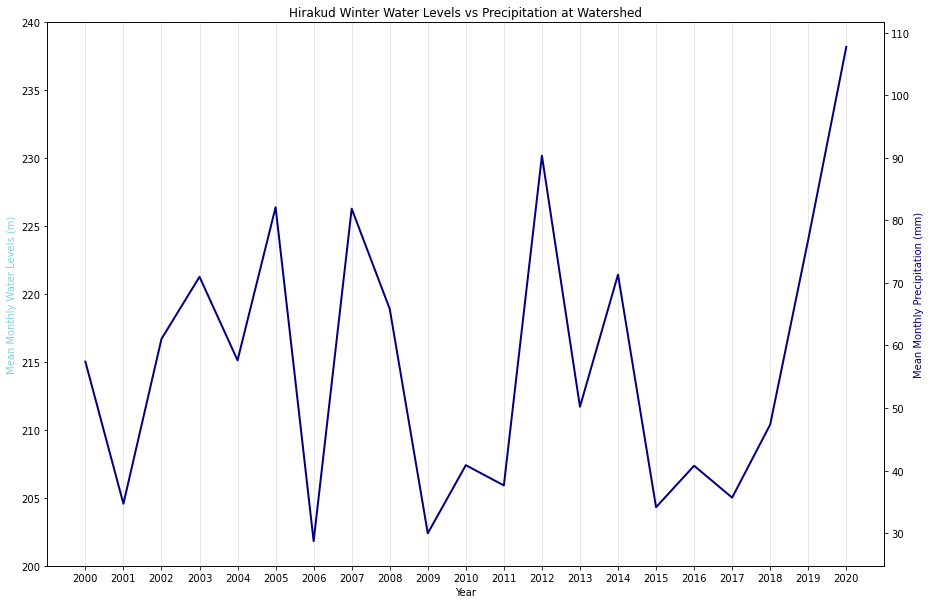

In [22]:
seas = 'Winter'
# Water Level vs. Temp
df_s = season_summary(seas)

x = seasonal_x
my_xticks = seasonal_x_txt

# Create Y values from reservoir and precip data
y1 = df_s[wl].tolist()
y2 = df_s[precip + "_at"].tolist()

# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'skyblue', linewidth =4 )
ax2.plot(x, y2, 'navy', linewidth =2 )
plt.xticks(x, my_xticks, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
ax1.set_ylim(200, 240)
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Mean Monthly Precipitation (mm)', color='navy')
ax1.title.set_text('{:s} {:s} Water Levels vs Precipitation at Watershed'.format(res, seas))
ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, axis = 'x')
plt.show()

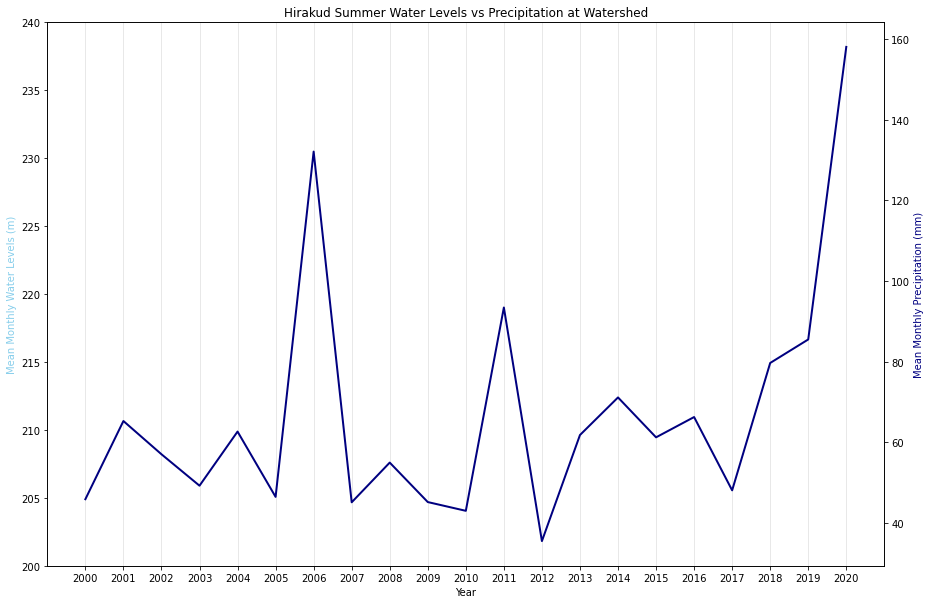

In [23]:
seas = 'Summer'
# Water Level vs. Temp
df_s = season_summary(seas)

x = seasonal_x
my_xticks = seasonal_x_txt

# Create Y values from reservoir and precip data
y1 = df_s[wl].tolist()
y2 = df_s[precip + "_at"].tolist()

# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, y1, 'skyblue', linewidth =4 )
ax2.plot(x, y2, 'navy', linewidth =2 )
plt.xticks(x, my_xticks, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
ax1.set_ylim(200, 240)
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Mean Monthly Precipitation (mm)', color='navy')
ax1.title.set_text('{:s} {:s} Water Levels vs Precipitation at Watershed'.format(res, seas))
ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, axis = 'x')
plt.show()

# Drought year

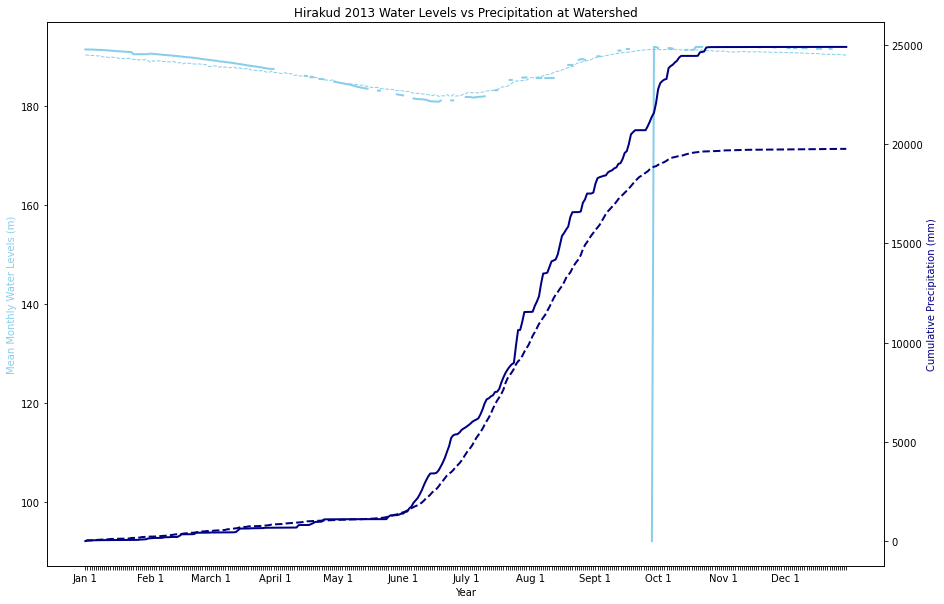

In [24]:
year = 2013
drought = df_daily[df_daily.Year == year]
nondrought = df_daily[df_daily.Year != year]
jd_nd =  nondrought.groupby(['JD'])[data_fields].mean().add_prefix("avg_")

# Set X
x = julian_x[0:365]
my_xticks = julian_x_txt[0:365]
# Create Y values from reservoir and precip data
yavg = jd_nd["avg_" + wl].tolist()[0:365]
ydrght = drought[wl].tolist()[0:365]
yrain = drought[precip + "_in"].cumsum().tolist()[0:365]
yavg_rain = jd_nd["avg_" + precip + "_in"].cumsum().tolist()[0:365]
# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, yavg, 'skyblue', linestyle= "--", linewidth =1 )
ax1.plot(x, ydrght, 'skyblue', linewidth =2 )
ax2.plot(x, yrain, 'navy', linewidth =2 )
ax2.plot(x, yavg_rain, 'navy', linestyle= "--", linewidth =2 )
plt.xticks(x, my_xticks, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
# ax1.set_ylim(200, 240)
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Cumulative Precipitation (mm)', color='navy')
ax1.title.set_text('{:s} {:s} Water Levels vs Precipitation at Watershed'.format(res, str(year)))
# ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, axis = 'x')
plt.show()

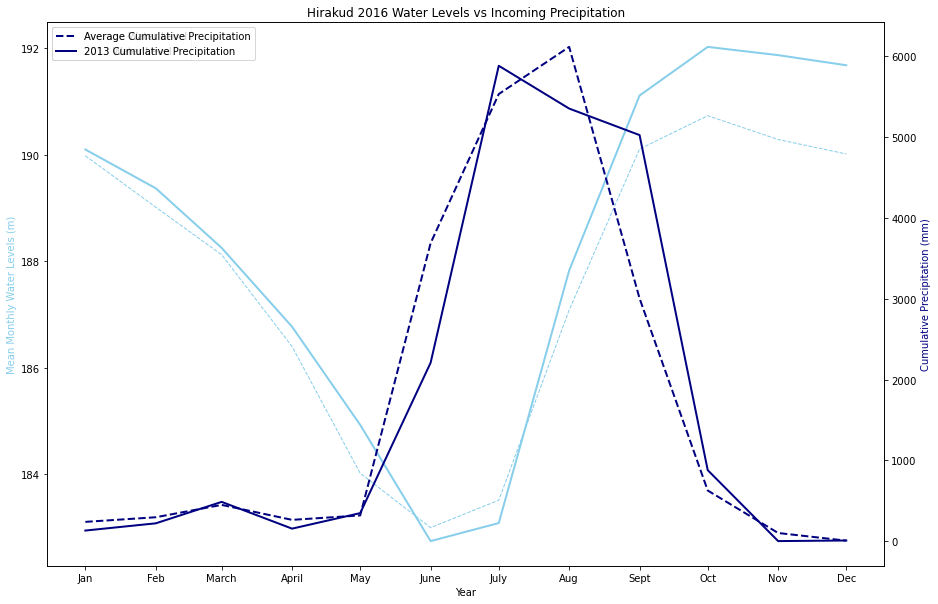

In [28]:
year = 2016
drought = df_monthly[df_monthly.Year == year]
nondrought = df_monthly[df_monthly.Year != year]
jd_nd =  nondrought.groupby(['JD'])[data_fields].mean().add_prefix("avg_")
jd_d =  drought.groupby(['JD'])[data_fields].mean().add_prefix("avg_")

jd_nd = jd_nd[jd_nd.index.isin(jd_d.index)]
# Set X
x = jd_d.index.tolist()
my_xticks = [x for x in month.values()]
# Create Y values from reservoir and precip data
yavg = jd_nd["avg_" + wl].tolist()[0:365]
ydrght = jd_d["avg_" + wl].tolist()[0:365]
yavg_rain = jd_nd["avg_" + precip + "_in"].tolist()[0:365]
yrain = jd_d["avg_" + precip + "_in"].tolist()[0:365]


# # Create plot
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(x, yavg, 'skyblue', linestyle= "--", linewidth =1 , label = "Average Water Level")
ax1.plot(x, ydrght, 'skyblue', linewidth =2 , label = "2013 Water Level")

ax2.plot(x, yavg_rain, 'navy', linestyle= "--", linewidth =2, label = "Average Cumulative Precipitation" )
ax2.plot(x, yrain, 'navy', linewidth =2, label = "2013 Cumulative Precipitation" )
plt.xticks(x, my_xticks, rotation=90) # Create plot labels
ax1.set_xlabel('Year')
# ax1.set_ylim(205, 245)
# ax2.set_ylim(0, 1300)
ax1.set_ylabel('Mean Monthly Water Levels (m)', color='skyblue')
ax2.set_ylabel('Cumulative Precipitation (mm)', color='navy')
ax1.title.set_text('{:s} {:s} Water Levels vs Incoming Precipitation'.format(res, str(year)))
ax1.legend()
ax2.legend(loc='upper left')
# ax1.grid(color='lightgray', linestyle='-', linewidth=0.5, axis = 'x')
plt.show()

# res_img = os.path.join(annual_path, "{:s}_{:s}.png".format(res, "4")) # Path to save image results
# fig.savefig(res_img, bbox_inches='tight')